# Experiment Log Analysis: Acceptance Rates vs Thresholds

This notebook analyzes the experiment summary log to visualize the relationship between acceptance rates (Draft and Target) and their respective thresholds.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
# Load the JSON data
file_path = "experiment_summary_20260126_185941.json"

with open(file_path, 'r') as f:
    data = json.load(f)

# Extract relevant fields
records = []
for entry in data:
    config = entry.get('config', {})
    result = entry.get('result', {})
    
    # Extract thresholds
    small_draft_thresh = config.get('small_draft_threshold')
    draft_target_thresh = config.get('draft_target_threshold')
    
    # Extract metrics for acceptance rate calculation
    little_accepted = result.get('little_accepted_tokens', 0)
    little_generated = result.get('little_generated_tokens', 0)
    
    draft_accepted = result.get('draft_accepted_tokens', 0)
    draft_generated = result.get('draft_generated_tokens', 0)
    
    # Calculate rates
    # Avoid division by zero
    little_acc_rate = little_accepted / little_generated if little_generated > 0 else 0
    draft_acc_rate = draft_accepted / draft_generated if draft_generated > 0 else 0
    
    records.append({
        'small_draft_threshold': small_draft_thresh,
        'draft_target_threshold': draft_target_thresh,
        'little_acceptance_rate': little_acc_rate,
        'draft_acceptance_rate': draft_acc_rate,
        'exp_name': entry.get('exp_name')
    })

df = pd.DataFrame(records)

# Display the first few rows and data types
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   small_draft_threshold   27 non-null     float64
 1   draft_target_threshold  27 non-null     float64
 2   little_acceptance_rate  27 non-null     float64
 3   draft_acceptance_rate   27 non-null     float64
 4   exp_name                27 non-null     object 
dtypes: float64(4), object(1)
memory usage: 1.2+ KB
None


,small_draft_threshold,draft_target_threshold,little_acceptance_rate,draft_acceptance_rate,exp_name
0,0.6,0.1,0.574321,1.732162,adaptive_tridecoding/mt_bench/adaptive_trideco...
1,0.6,0.2,0.574203,1.679132,adaptive_tridecoding/mt_bench/adaptive_trideco...
2,0.6,0.3,0.000000,0.000000,adaptive_tridecoding/mt_bench/adaptive_trideco...
3,0.7,0.1,0.556844,1.763653,adaptive_tridecoding/mt_bench/adaptive_trideco...
4,0.7,0.2,0.557959,1.710177,adaptive_tridecoding/mt_bench/adaptive_trideco...


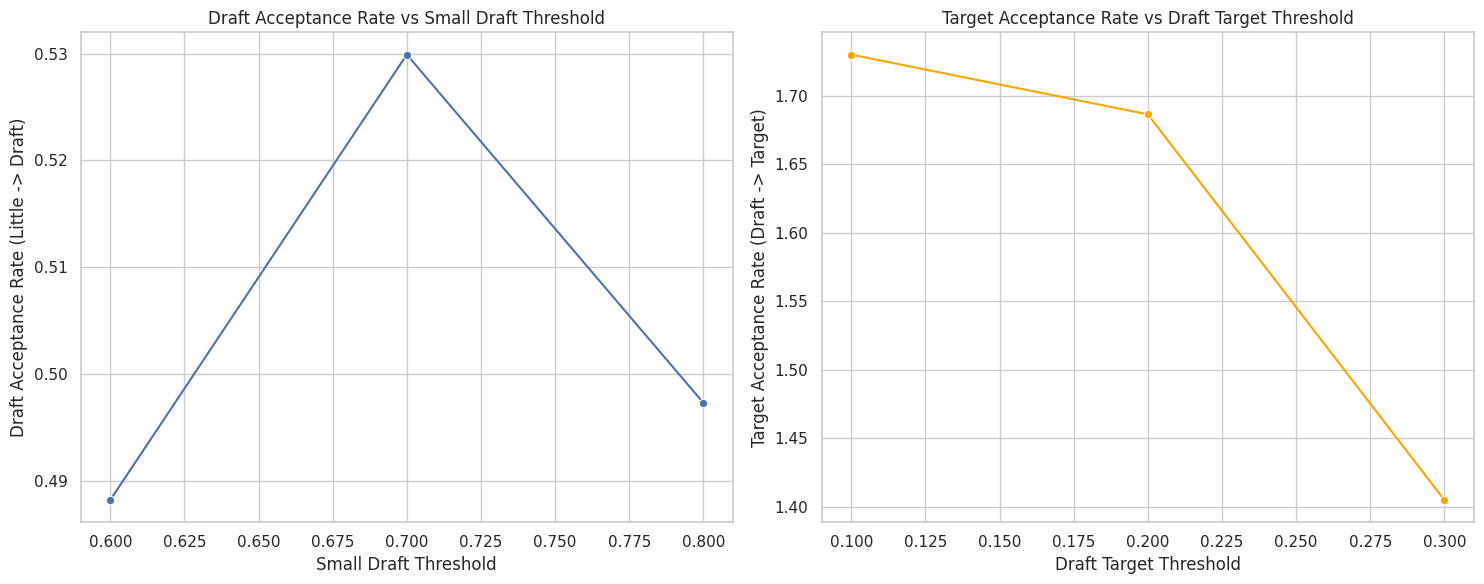

In [3]:
# Aggregate data by thresholds
# Group by small_draft_threshold to see its effect on little_acceptance_rate (Draft Acceptance)
draft_acc_by_thresh = df.groupby('small_draft_threshold')['little_acceptance_rate'].mean().reset_index()

# Group by draft_target_threshold to see its effect on draft_acceptance_rate (Target Acceptance)
target_acc_by_thresh = df.groupby('draft_target_threshold')['draft_acceptance_rate'].mean().reset_index()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Draft Acceptance Rate vs Small Draft Threshold
sns.lineplot(data=draft_acc_by_thresh, x='small_draft_threshold', y='little_acceptance_rate', marker='o', ax=axes[0])
axes[0].set_title('Draft Acceptance Rate vs Small Draft Threshold')
axes[0].set_xlabel('Small Draft Threshold')
axes[0].set_ylabel('Draft Acceptance Rate (Little -> Draft)')

# Plot 2: Target Acceptance Rate vs Draft Target Threshold
sns.lineplot(data=target_acc_by_thresh, x='draft_target_threshold', y='draft_acceptance_rate', marker='o', ax=axes[1], color='orange')
axes[1].set_title('Target Acceptance Rate vs Draft Target Threshold')
axes[1].set_xlabel('Draft Target Threshold')
axes[1].set_ylabel('Target Acceptance Rate (Draft -> Target)')

plt.tight_layout()
plt.show()

## Analysis Summary

The plots above visualize how the acceptance rates change with their respective thresholds:
1.  **Left Plot**: Shows how the acceptance rate of the "Little" model (by the Draft model) varies with the `small_draft_threshold`.
2.  **Right Plot**: Shows how the acceptance rate of the "Draft" model (by the Target model) varies with the `draft_target_threshold`.

This separation allows for independent analysis of the two stages in the adaptive tri-decoding process.